# 추세/변동성 분석

## 목표
+ 외국인 보유량의 단기,중기 추세 비교
+ 일자별 증감률(%) 계산
+ 급변(+-2% 이상)날짜 탐지

### 1. 이동평균선(MA5,MA20)

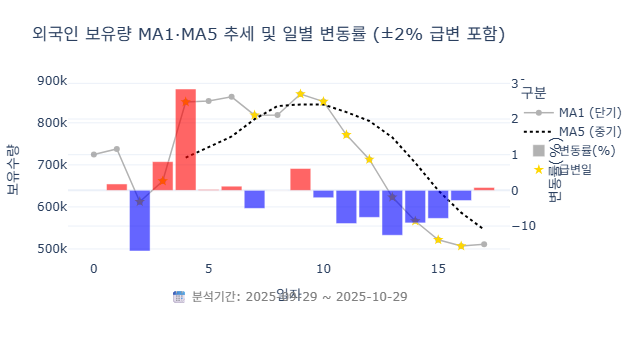

In [23]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# 데이터 로드
df = pd.read_csv("C:/work/텐트메이커/데이터분석/data/모비스_주식_외국인보유량데이터.csv",
                 encoding="utf-8-sig")

# 컬럼 공백 제거
df.columns = df.columns.str.replace(r'\s+', '', regex=True)

# 이동평균선
df['MA1'] = df['외국인보유수량']
df['MA5'] = df['외국인보유수량'].rolling(5).mean()

# 변동률 계산
df['변동률(%)'] = df['외국인보유수량'].pct_change() * 100

# 급변 여부 및 색상
df['급변여부'] = df['변동률(%)'].apply(lambda x: '급변' if abs(x) >= 2 else '보통')
df['색상'] = df['변동률(%)'].apply(lambda x: 'red' if x > 0 else ('blue' if x < 0 else 'gray'))

# ---------------------------
# 시각화
# ---------------------------
fig = go.Figure()

# MA1
fig.add_trace(go.Scatter(x=df.index, y=df['MA1'],
                         mode='lines+markers', name='MA1 (단기)',
                         line=dict(color='gray', width=1.5), opacity=0.6))
# MA5
fig.add_trace(go.Scatter(x=df.index, y=df['MA5'],
                         mode='lines', name='MA5 (중기)',
                         line=dict(color='black', dash='dot', width=2)))

# 변동률 (이중축)
fig.add_trace(go.Bar(x=df.index, y=df['변동률(%)'],
                     name='변동률(%)', marker_color=df['색상'],
                     opacity=0.6, yaxis='y2'))

# 급변일
spike = df[df['급변여부'] == '급변']
fig.add_trace(go.Scatter(x=spike.index, y=spike['MA1'],
                         mode='markers', name='급변일',
                         marker=dict(color='gold', size=8, symbol='star')))

# ---------------------------
# 하단 기간 표기
# ---------------------------
fig.add_annotation(
    text="📆 분석기간: 2025-09-29 ~ 2025-10-29",
    xref="paper", yref="paper",
    x=0.5, y=-0.25, showarrow=False,
    font=dict(size=12, color="gray")
)

# 레이아웃
fig.update_layout(
    title='외국인 보유량 MA1·MA5 추세 및 일별 변동률 (±2% 급변 포함)',
    xaxis_title='일자',
    yaxis=dict(title='보유수량'),
    yaxis2=dict(title='변동률(%)', overlaying='y', side='right'),
    legend_title='구분',
    template='plotly_white',
    bargap=0.1,
    margin=dict(l=50, r=50, t=80, b=100)  # 아래 여백 확보
)

fig.show()

### 2.구간별 비교 분석

📋 주차별 평균 외국인 보유량 / 변동률 / 종가 요약:
    주차   외국인보유수량  변동률(%)        종가
0  1.0  717277.8   5.315  2833.000
1  2.0  843735.0   0.503  2780.000
2  3.0  705015.0  -8.129  2755.000
3  4.0  513432.0  -3.298  2618.333


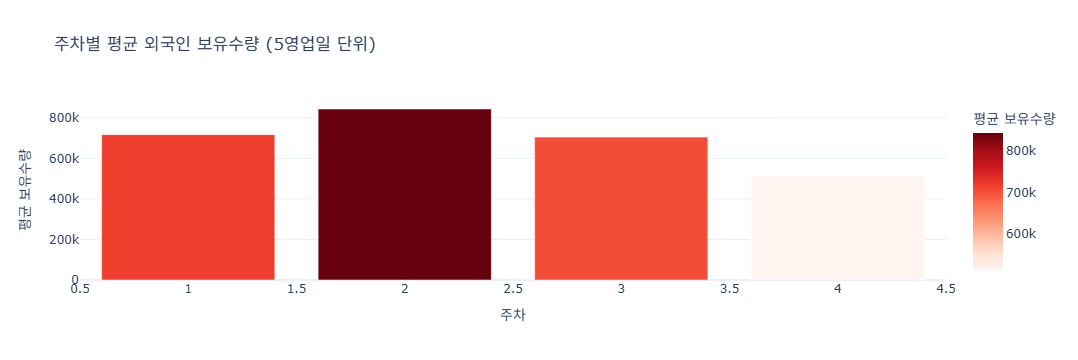

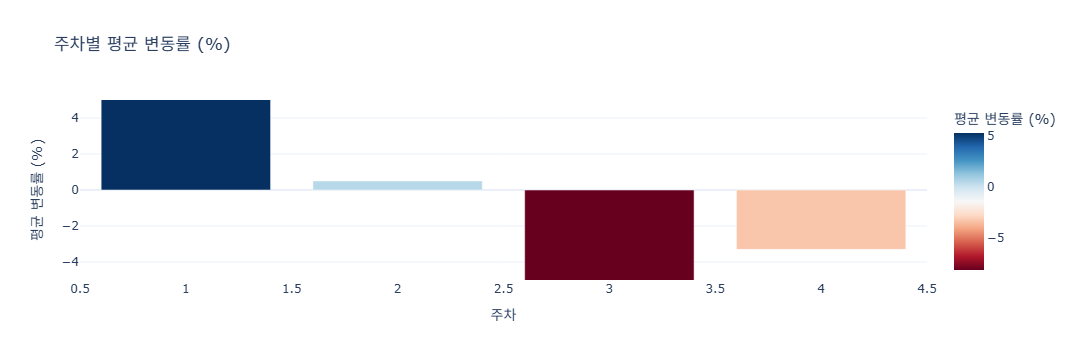

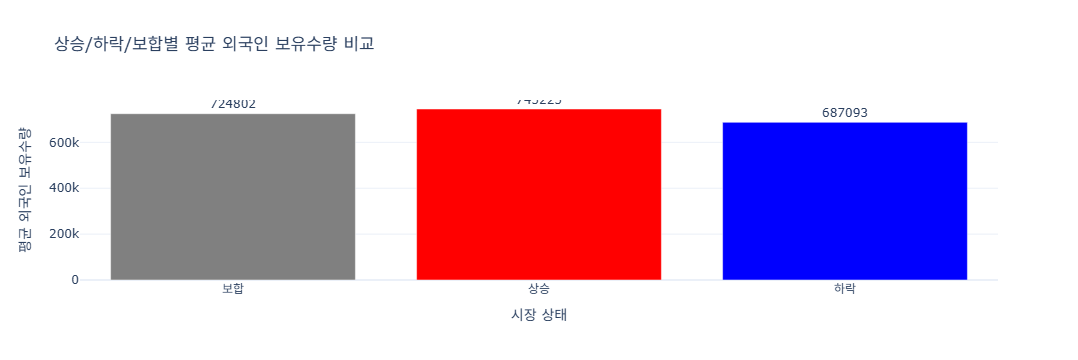

In [25]:
# 종가 기준 상승/하락/보합 구분
df['전일종가'] = df['종가'].shift(1)
df['등락'] = df['종가'] - df['전일종가']
df['장상태'] = df['등락'].apply(lambda x: '상승' if x > 0 else ('하락' if x < 0 else '보합'))

# 5영업일 단위 구간 ID 부여
df['주차'] = (df.index.to_series().rank(method='dense') - 1) // 5 + 1

# 주차별 평균값 계산
weekly = df.groupby('주차').agg({
    '외국인보유수량': 'mean',
    '변동률(%)': 'mean',
    '종가': 'mean'
}).reset_index()

print("📋 주차별 평균 외국인 보유량 / 변동률 / 종가 요약:")
print(weekly.round(3))

# ---------------------------
# 그래프 A: 주차별 외국인 보유량
# ---------------------------
fig1 = px.bar(
    weekly,
    x='주차', y='외국인보유수량',
    title='주차별 평균 외국인 보유수량 (5영업일 단위)',
    labels={'외국인보유수량': '평균 보유수량'},
    color='외국인보유수량',
    color_continuous_scale='reds'
)
fig1.update_layout(template='plotly_white')
fig1.show()

# ---------------------------
# 그래프 B: 주차별 평균 변동률
# ---------------------------
fig2 = px.bar(
    weekly,
    x='주차', y='변동률(%)',
    title='주차별 평균 변동률 (%)',
    labels={'변동률(%)': '평균 변동률 (%)'},
    color='변동률(%)',
    color_continuous_scale='RdBu'
)
fig2.update_yaxes(range=[-5, 5])  # ±5% 고정
fig2.update_layout(template='plotly_white')
fig2.show()

# ---------------------------
# 그래프 C: 상승/하락/보합별 평균 외국인 보유량 비교
# ---------------------------
compare = df.groupby('장상태')['외국인보유수량'].mean().reset_index()
compare['색상'] = compare['장상태'].map({'상승':'red', '하락':'blue', '보합':'gray'})

fig3 = go.Figure()
fig3.add_trace(go.Bar(
    x=compare['장상태'], y=compare['외국인보유수량'],
    marker_color=compare['색상'],
    text=compare['외국인보유수량'].round(0),
    textposition='outside'
))
fig3.update_layout(
    title='상승/하락/보합별 평균 외국인 보유수량 비교',
    xaxis_title='시장 상태',
    yaxis_title='평균 외국인 보유수량',
    template='plotly_white'
)
fig3.show()